In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
PW = 8
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
plt.rcParams['image.cmap'] = 'gray'

import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 250
pd.options.display.max_columns = 500
pd.options.display.max_colwidth = 500

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import string 
import warnings

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['glove.6B.100d.txt', 'glove.6B.300d.txt', '.ipynb_checkpoints', 'README.md', 'mbti_1.csv', '.git', 'PT.ipynb', 'glove.6B.200d.txt', 'glove.6B.50d.txt']


In [2]:
df = pd.read_csv("./mbti_1.csv", encoding="utf-8")
print("Number of users", len(df))

Number of users 8675


## Explore

In [3]:
df.head(3)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.|||May the PerC Experience immerse you.|||The last ...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin* That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes. Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your o..."


In [4]:
#Personality Types
groups = df.groupby("type").count()
groups.sort_values("posts", ascending=False, inplace=True)
print ("Personality types", groups.index.values)

#Priors used below
priors = groups["posts"] / groups["posts"].sum()

Personality types ['INFP' 'INFJ' 'INTP' 'INTJ' 'ENTP' 'ENFP' 'ISTP' 'ISFP' 'ENTJ' 'ISTJ'
 'ENFJ' 'ISFJ' 'ESTP' 'ESFP' 'ESFJ' 'ESTJ']


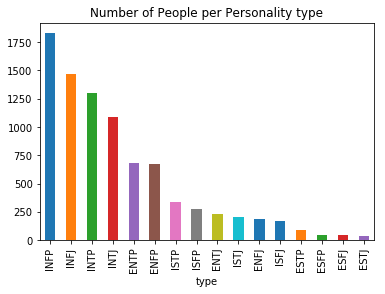

In [5]:
groups["posts"].plot(kind="bar", title="Number of People per Personality type");

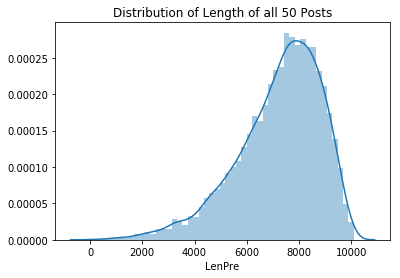

In [6]:
df["LenPre"] = df["posts"].apply(len)
sns.distplot(df["LenPre"]).set_title("Distribution of Length of all 50 Posts");

In [7]:
def preprocess_text(df, remove_special=True):
    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep EOS
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #To lower
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove short/long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove Personality Types Words
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    df["posts"] = df["posts"].apply(lambda x: p.sub(' PTypeToken ',x))
    return df

def subsample(df):
    groups = df.groupby("type").count()
    groups.sort_values("posts", ascending=False, inplace=True)
    
    min_num = groups["posts"][-1]
    min_ind = groups.index[-1]
    ndf = df[df["type"] == min_ind]

    for pt in groups.index[:-1]:
        print(min_num,pt)
        tdf = df[df["type"] == pt].sample(min_num)
        ndf = pd.concat([ndf, tdf])
    return ndf

## Split Posts

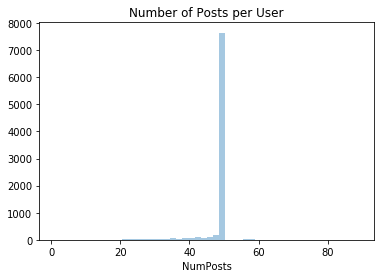

In [8]:
#Number of Posts per User
df["NumPosts"] = df["posts"].apply(lambda x: len(x.split("|||")))

sns.distplot(df["NumPosts"], kde=False).set_title("Number of Posts per User");

In [9]:
#Split to posts
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df), "Number of posts", len(posts))

df = pd.DataFrame(posts, columns=["type", "posts"])

Number of users 8675 Number of posts 422845


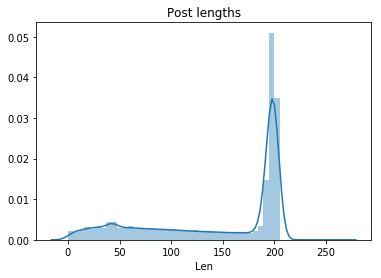

In [10]:
df["Len"] = df["posts"].apply(len)
sns.distplot(df["Len"]).set_title("Post lengths");

In [11]:
#Preprocess Text
df = preprocess_text(df) 

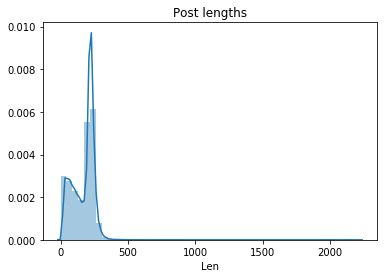

In [12]:
df["Len"] = df["posts"].apply(len)
sns.distplot(df["Len"]).set_title("Post lengths");

In [13]:
#Remove posts with less than X words
min_words = 15
print("Number of posts", len(df)) 
df["nw"] = df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
df = df[df["nw"] >= min_words]
print("Number of posts", len(df)) 

Number of posts 422845
Number of posts 275034


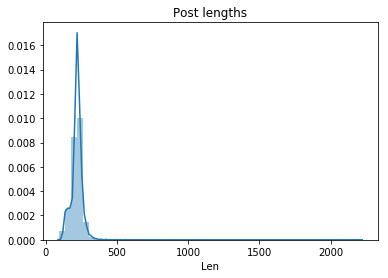

In [14]:
df["Len"] = df["posts"].apply(len)
sns.distplot(df["Len"]).set_title("Post lengths");

In [15]:
#Remove long post
max_length = 350
print("Number of posts", len(df)) 
df = df[df["Len"] < 350]
print("Number of posts", len(df)) 

Number of posts 275034
Number of posts 273972


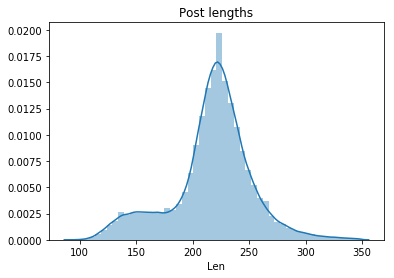

In [16]:
df["Len"] = df["posts"].apply(len)
sns.distplot(df["Len"]).set_title("Post lengths");

In [17]:
#Drop nw Len
df.drop(["nw", "Len"],axis=1, inplace=True)

In [18]:
#Subsample
#df = subsample(df)

## Stemming

In [19]:
#Stem
stemmer = SnowballStemmer("english")

df["posts"] = df["posts"].apply(lambda x: " ".join(stemmer.stem(p) for p in x.split(" ")))

## BOW Models

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [266]:
#For Naive Bayes
vect = CountVectorizer(stop_words='english') 
#vect = TfidfVectorizer(stop_words='english')
X =  vect.fit_transform(df["posts"]) 

le = LabelEncoder()
y = le.fit_transform(df["type"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## Random Estimation

In [21]:
def cat_accuracy(yp_test, y_test, le):
    ype = np.array(list("".join(le.inverse_transform(yp_test))))
    ye = np.array(list("".join(le.inverse_transform(y_test))))
    return (ype == ye).mean()

def predict_random_guess(priors, lp):
    return np.random.choice(priors.index, lp, p=priors.values)


In [268]:
num_iter = 100
mc16 = np.zeros(num_iter)
mc4 = np.zeros(num_iter)

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
for i in range(100):
    mc16[i] = np.mean(le.transform(predict_random_guess(priors, len(y_test))) == y_test)
    mc4[i] = cat_accuracy(le.transform(predict_random_guess(priors, len(y_test))), y_test, le)


print ("Random guessing 16 Types:", mc16.mean(), mc16.std())
print ("Random Guessing 4 Categories:", mc4.mean(), mc4.std())

Random guessing 16 Types: 0.12991167238484563 0.0020467186813161974
Random Guessing 4 Categories: 0.6094468574348492 0.0013451555081418073


## NaiveBayes

In [269]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

yp_train = clf.predict(X_train)
print("Train accuracy:", np.mean(yp_train == y_train))

yp_test = clf.predict(X_test)
print("Test accuracy:", np.mean(yp_test == y_test))

print("Categorical accuracy:", cat_accuracy(yp_test, y_test, le))

Train accuracy: 0.3555606024966136
Test accuracy: 0.2433754288634207
Categorical accuracy: 0.7011734433170305


## Word Lengths Disttribution

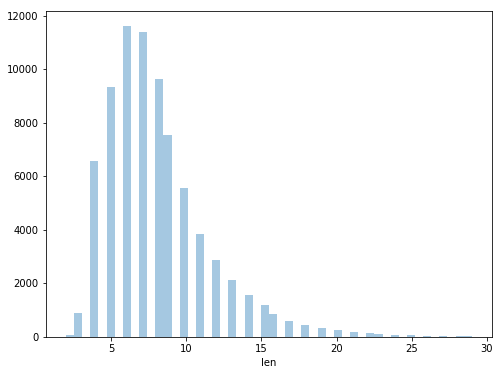

In [270]:
wdf = pd.DataFrame( vect.get_feature_names(),columns=["word"])
wdf["len"] = wdf.word.apply(len)
sns.distplot(wdf["len"], kde=False);

## Sequential Models

In [129]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense,  Dropout, Flatten
from keras.layers import LSTM, Conv1D, Input, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import OneHotEncoder

from scipy import spatial
from sklearn.utils import class_weight

In [130]:
def cat_accu_seq(X_test, y_test, model):
    yp_test = model.predict(X_test)

    yp_test_d =  np.argmax(yp_test, axis=1)
    y_test_d =  np.argmax(y_test, axis=1)
    
    return  cat_accuracy(yp_test_d, y_test_d, le )

def calc_weights(df, le, ohe):
    groups = df.groupby("type").count()
    groups.sort_values("posts", ascending=False, inplace=True)
    
    p = groups["posts"]#.to_dict()
    ohe.transform([[x] for x in le.transform(p.index.values)])

In [131]:
#Prepare X and y
X =  df.posts

le = LabelEncoder()
y = le.fit_transform(df["type"])

ohe = OneHotEncoder(n_values='auto',  sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))

In [132]:
max_nb_words = 77541#50000

#Tokenize words
tokenizer = Tokenizer(nb_words=max_nb_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#Constants
ptypes_num = 16
max_post_len = np.max([ len(x) for x in sequences])

/home/brunno/anaconda2/envs/ana41py35/lib/python3.5/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 77541 unique tokens.


In [133]:
#Pad
sequences = sequence.pad_sequences(sequences, maxlen=max_post_len) 

In [134]:
#Split
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size=0.1, stratify=y, random_state=42)

In [143]:
#pd.DataFrame(y_test)[0].value_counts().plot(kind="bar");

In [144]:
#temp = [np.argmax(x) for x in y_test]
#pd.DataFrame(temp)[0].value_counts().plot(kind="bar");

In [145]:
#Constants
batch_size = 512
epochs = 5
embedding_vecor_length = 32
lstm_size = 32

model = Sequential()
model.add(Embedding(max_nb_words, embedding_vecor_length, input_length=max_post_len))
model.add(Dropout(0.25))

# model.add(LSTM(lstm_size, return_sequences=True))
#model.add(Dropout(0.25))

model.add(LSTM(lstm_size))
model.add(Dropout(0.25))

model.add(Dense(ptypes_num, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 32)            2481312   
_________________________________________________________________
dropout_17 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
Total params: 2,490,160
Trainable params: 2,490,160
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
#Class Weights
wy = le.fit_transform(df["type"])
cw = class_weight.compute_class_weight('balanced', np.unique(wy), wy)

In [147]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=cw, validation_data=(X_test, y_test))

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Categorical Accuracy:", cat_accu_seq(X_test, y_test, model))

Train on 246574 samples, validate on 27398 samples
Epoch 1/5
246574/246574 [==============================] - 76s 307us/step - loss: 2.3072 - acc: 0.2036 - val_loss: 2.2510 - val_acc: 0.2140
Epoch 2/5
246574/246574 [==============================] - 77s 314us/step - loss: 2.2313 - acc: 0.2244 - val_loss: 2.2165 - val_acc: 0.2324
Epoch 3/5
246574/246574 [==============================] - 83s 336us/step - loss: 2.1909 - acc: 0.2385 - val_loss: 2.2188 - val_acc: 0.2347
Epoch 4/5
246574/246574 [==============================] - 83s 337us/step - loss: 2.1564 - acc: 0.2529 - val_loss: 2.2228 - val_acc: 0.2362
Epoch 5/5
246574/246574 [==============================] - 76s 308us/step - loss: 2.1181 - acc: 0.2731 - val_loss: 2.2362 - val_acc: 0.2331
Accuracy: 23.31%
Categorical Accuracy: 0.6992846193152785


/home/brunno/anaconda2/envs/ana41py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/brunno/anaconda2/envs/ana41py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Plot Predictions

In [102]:
yp_test =  np.argmax(model.predict(X_test), axis=1)

dft = pd.DataFrame(le.inverse_transform(yp_test),columns=["pred"])
dft["cnt"] =  1
dft["same"] = (yp_test == np.argmax(y_test, axis=1))
dft["same"] = dft["same"].astype(int)

groupsn = dft.groupby("pred").sum()
groupsn.sort_values("cnt", ascending=False, inplace=True)

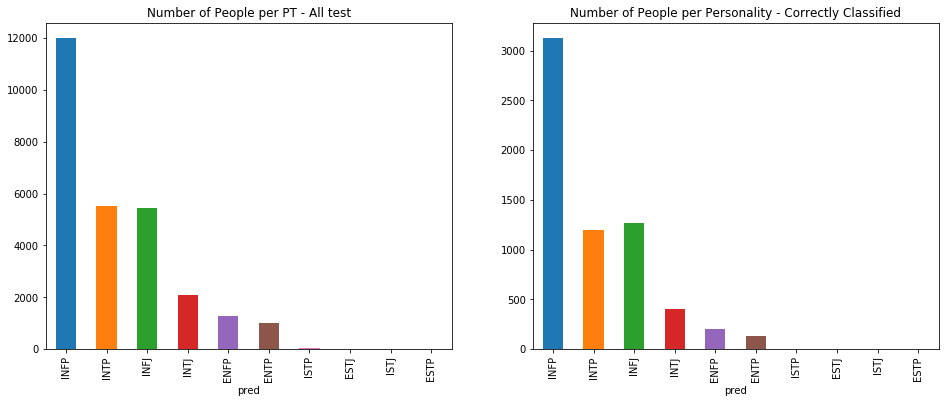

In [96]:
f, ax = plt.subplots(1,2,figsize=(2*PW,PH))
groupsn["cnt"].plot(kind="bar", title="Number of People per PT - All test", ax=ax[0]);
groupsn["same"].plot(kind="bar", title="Number of People per Personality - Correctly Classified", ax=ax[1]);

## Word Embedings

In [281]:
path_emb = 'glove.6B.50d.txt'
EMBEDDING_DIM = 50

embeddings_index = {}
f = open(path_emb)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [282]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [283]:
def cos_sim(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

def find_pair(w1,w2,w3,embeddings_index):
    
    v1 = embeddings_index[w1] ## "king"
    v2 = embeddings_index[w2] ## "queen"
    diff = v2 - v1
    
    v3 = embeddings_index[w3] + diff ## "man"
    
    cos_sim_min = -100
    sim_word = "" 
    for word in embeddings_index.keys():
        v4 = embeddings_index[word]
        if cos_sim(v3, v4) > cos_sim_min:
            cos_sim_min = cos_sim(v3, v4)
            sim_word = word         
    
    return sim_word ##woman

In [284]:
#find_pair("up", "down", "upper", embeddings_index)

In [285]:
#Constants
batch_size = 512
epochs = 6
lstm_size = 32

# create the model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=max_post_len,
                    trainable=False))
model.add(Dropout(0.1))

# model.add(LSTM(lstm_size, return_sequences=True))
# model.add(Dropout(0.25))

model.add(LSTM(lstm_size))
model.add(Dropout(0.1))

model.add(Dense(ptypes_num, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 40, 50)            3877100   
_________________________________________________________________
dropout_25 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                10624     
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
Total params: 3,888,252
Trainable params: 11,152
Non-trainable params: 3,877,100
_________________________________________________________________
None


In [286]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Categorical Accuracy:", cat_accu_seq(X_test, y_test, model))

Train on 246574 samples, validate on 27398 samples
Epoch 1/6
246574/246574 [==============================] - 50s 204us/step - loss: 2.2964 - acc: 0.2019 - val_loss: 2.2514 - val_acc: 0.2191
Epoch 2/6
246574/246574 [==============================] - 49s 197us/step - loss: 2.2561 - acc: 0.2145 - val_loss: 2.2449 - val_acc: 0.2210
Epoch 3/6
246574/246574 [==============================] - 49s 198us/step - loss: 2.2492 - acc: 0.2180 - val_loss: 2.2422 - val_acc: 0.2214
Epoch 4/6
246574/246574 [==============================] - 49s 200us/step - loss: 2.2453 - acc: 0.2198 - val_loss: 2.2391 - val_acc: 0.2241
Epoch 5/6
246574/246574 [==============================] - 50s 201us/step - loss: 2.2426 - acc: 0.2206 - val_loss: 2.2357 - val_acc: 0.2247
Epoch 6/6
246574/246574 [==============================] - 50s 201us/step - loss: 2.2397 - acc: 0.2229 - val_loss: 2.2341 - val_acc: 0.2253
Accuracy: 22.53%
Categorical Accuracy: 0.7044492298707935
